In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os,sys
sys.path.insert(0,"..")
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import sys
import torch.nn.functional as F
import tqdm
import sklearn, sklearn.metrics
import pandas as pd
import torchxrayvision as xrv

In [3]:
d_nih = xrv.datasets.NIH_Dataset(imgpath="/home/users/joecohen/group/joecohen/images-512-NIH")
xrv.datasets.relabel_dataset(xrv.datasets.default_pathologies, d_nih)

Lung Lesion doesn't exist. Adding nans instead.
Fracture doesn't exist. Adding nans instead.
Lung Opacity doesn't exist. Adding nans instead.
Enlarged Cardiomediastinum doesn't exist. Adding nans instead.


In [4]:
d_pc = xrv.datasets.PC_Dataset(imgpath="/home/users/joecohen/group/joecohen/images-512-PC")
xrv.datasets.relabel_dataset(xrv.datasets.default_pathologies, d_pc)

{'Tube', 'Aortic Atheromatosis', 'Tuberculosis', 'Aortic Elongation', 'Hemidiaphragm Elevation', 'Flattened Diaphragm', 'Support Devices', 'Costophrenic Angle Blunting', 'Air Trapping', 'Scoliosis', 'Hilar Enlargement', 'Bronchiectasis', 'Granuloma'} will be dropped
Lung Lesion doesn't exist. Adding nans instead.
Lung Opacity doesn't exist. Adding nans instead.
Enlarged Cardiomediastinum doesn't exist. Adding nans instead.


{'Atelectasis': 0.0,
 'Consolidation': 1.0,
 'Infiltration': 1.0,
 'Pneumothorax': 0.0,
 'Edema': 0.0,
 'Emphysema': 0.0,
 'Fibrosis': 0.0,
 'Effusion': 1.0,
 'Pneumonia': 0.0,
 'Pleural_Thickening': 0.0,
 'Cardiomegaly': 0.0,
 'Nodule': 0.0,
 'Mass': 0.0,
 'Hernia': 0.0,
 'Lung Lesion': nan,
 'Fracture': nan,
 'Lung Opacity': nan,
 'Enlarged Cardiomediastinum': nan}

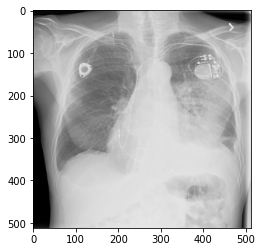

In [5]:
sample = d_nih[40]
plt.imshow(sample["img"][0], cmap="Greys_r");
dict(zip(d_pc.pathologies,sample["lab"]))

In [6]:
model = xrv.models.DenseNet(weights="all")
# does the model align with the dataset?
dict(zip(model.pathologies,xrv.datasets.default_pathologies))

{'Atelectasis': 'Atelectasis',
 'Consolidation': 'Consolidation',
 'Infiltration': 'Infiltration',
 'Pneumothorax': 'Pneumothorax',
 'Edema': 'Edema',
 'Emphysema': 'Emphysema',
 'Fibrosis': 'Fibrosis',
 'Effusion': 'Effusion',
 'Pneumonia': 'Pneumonia',
 'Pleural_Thickening': 'Pleural_Thickening',
 'Cardiomegaly': 'Cardiomegaly',
 'Nodule': 'Nodule',
 'Mass': 'Mass',
 'Hernia': 'Hernia',
 'Lung Lesion': 'Lung Lesion',
 'Fracture': 'Fracture',
 'Lung Opacity': 'Lung Opacity',
 'Enlarged Cardiomediastinum': 'Enlarged Cardiomediastinum'}

In [7]:
model = xrv.models.DenseNet(weights="all")
with torch.no_grad():
    out = model(torch.from_numpy(sample["img"]).unsqueeze(0)).cpu()
    
dict(zip(model.pathologies,zip(out[0].detach().numpy(), sample["lab"])))

{'Atelectasis': (0.54616153, 0.0),
 'Consolidation': (0.5414902, 1.0),
 'Infiltration': (0.58784056, 1.0),
 'Pneumothorax': (0.5097357, 0.0),
 'Edema': (0.1553145, 0.0),
 'Emphysema': (0.5164833, 0.0),
 'Fibrosis': (0.5037881, 0.0),
 'Effusion': (0.536857, 1.0),
 'Pneumonia': (0.6651179, 0.0),
 'Pleural_Thickening': (0.53961545, 0.0),
 'Cardiomegaly': (0.39778435, 0.0),
 'Nodule': (0.5290049, 0.0),
 'Mass': (0.612293, 0.0),
 'Hernia': (0.24932922, 0.0),
 'Lung Lesion': (0.035506018, nan),
 'Fracture': (0.47508, nan),
 'Lung Opacity': (0.7333375, nan),
 'Enlarged Cardiomediastinum': (0.51983666, nan)}

In [8]:
model = xrv.models.DenseNet(weights="nih")
with torch.no_grad():
    out = model(torch.from_numpy(sample["img"]).unsqueeze(0)).cpu()
    
dict(zip(model.pathologies,zip(out[0].detach().numpy(), sample["lab"])))

{'Atelectasis': (0.5583771, 0.0),
 'Consolidation': (0.5279943, 1.0),
 'Infiltration': (0.60061914, 1.0),
 'Pneumothorax': (0.5082071, 0.0),
 'Edema': (0.5038578, 0.0),
 'Emphysema': (0.5029421, 0.0),
 'Fibrosis': (0.50516164, 0.0),
 'Effusion': (0.7720166, 1.0),
 'Pneumonia': (0.50302047, 0.0),
 'Pleural_Thickening': (0.62468415, 0.0),
 'Cardiomegaly': (0.5258018, 0.0),
 'Nodule': (0.5501213, 0.0),
 'Mass': (0.6658441, 0.0),
 'Hernia': (0.5014529, 0.0),
 '': (0.5, nan)}

In [9]:
# small test eval
model = xrv.models.DenseNet(weights="all")
if torch.cuda.is_available():
    model = model.cuda()

In [10]:
outs = []
labs = []
with torch.no_grad():
    np.random.seed(0)
    for i in tqdm.tqdm(np.random.randint(0,len(d_nih),500)):
        sample = d_nih[i]
        labs.append(sample["lab"])
        image = torch.from_numpy(sample["img"]).unsqueeze(0)
        if torch.cuda.is_available():
            image = image.cuda()
        out = model(image).cpu()
        outs.append(out.detach().numpy()[0])

  0%|          | 1/500 [00:00<01:36,  5.16it/s]

100%|██████████| 500/500 [00:24<00:00, 20.46it/s]


In [11]:
results = []
for i in range(14):
    result = {}
    result["Pathology"] = model.pathologies[i]
    if len(np.unique(np.asarray(labs)[:,i])) > 1:
        labels = np.asarray(labs)[:,i].astype(bool)
        preds = np.asarray(outs)[:,i]
        result["AUC"] = sklearn.metrics.roc_auc_score(labels, preds)
        result["Acc"] = sklearn.metrics.accuracy_score(labels, preds > 0.5)
        result["F1"] = sklearn.metrics.f1_score(labels, preds > 0.5)
    results.append(result)
        

In [12]:
pd.DataFrame(results)

,Pathology,AUC,Acc,F1
0,Atelectasis,0.819613,0.808,0.261538
1,Consolidation,0.715155,0.892,0.100000
2,Infiltration,0.641398,0.472,0.241379
3,Pneumothorax,0.895393,0.872,0.135135
4,Edema,NaN,NaN,NaN
5,Emphysema,0.881552,0.684,0.048193
6,Fibrosis,0.822458,0.504,0.074627
7,Effusion,0.911944,0.930,0.444444
8,Pneumonia,NaN,NaN,NaN
9,Pleural_Thickening,0.904980,0.780,0.098361
